In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import os

from fractions import Fraction
import functools
import math

from Bio import Entrez
Entrez.email = "halabikeren@mail.tau.ac.il"

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=10, use_memory_fs=False)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [19]:
networks_dir = "../../data/networks/"
aggregated_networks_dir = f"{networks_dir}/all/"

all_binary_networks_dir = f"{aggregated_networks_dir}binary/"
os.makedirs(all_binary_networks_dir, exist_ok=True)

all_weighted_networks_dir = f"{aggregated_networks_dir}weighted/"
os.makedirs(all_weighted_networks_dir, exist_ok=True)

all_binarized_weighted_networks_dir = f"{aggregated_networks_dir}binarized_weighted/"
os.makedirs(all_binarized_weighted_networks_dir, exist_ok=True)

sources = ["iwdb", "literature", "mangal", "web_of_life"]

name_resolution_path = "../../data/name_resolution/resolved_plant_names.csv"

In [3]:
name_resolution = None
if os.path.exists(name_resolution_path):
    name_resolution = pd.read_csv(name_resolution_path)

In [4]:
# # unzip dirs if neccessary
# for source in sources:
#     zip_path = f"../../data/networks/{source}.zip"
#     if os.path.exists(zip_path):
#         res = os.system(f"cd ../../data/networks;unzip -o {source}.zip")

In [44]:
def is_network_legal(network: pd.DataFrame):
    is_net_positive = np.all(network.set_index("Plant").dropna() >= 0)
    return is_net_positive

def is_network_resolved(network: pd.DataFrame, name_resolution=name_resolution):
    is_resolved=True
    if type(name_resolution) == pd.DataFrame:
        is_resolved = len(set(name_resolution.original_name.str.lower()) & set(network.Plant.str.lower())) > 0     
    return is_resolved

def is_binary(network: pd.DataFrame) -> bool:
    cond1 = np.all(network.set_index("Plant").fillna(0).to_numpy() % 1 == 0)
    cond2 = np.all(network.set_index("Plant").fillna(0).to_numpy() <= 1)
    return cond1 and cond2

def need_transpose(network: pd.DataFrame, output_path:str):
    row_sp = network.Plant.tolist()
    taxids = []
    for sp in row_sp:
        try:
            taxid = Entrez.read(Entrez.esearch(term=sp, db="taxonomy", retmode="xml"))["IdList"][0]
            taxids.append(taxid)
        except Exception as e:
            continue
        if len(taxids) > 1:
            break
    if len(taxids) == 0:
        print(f"could not extract taxids for the network in {output_path}")
        return False
    try:
        tax_data = list(Entrez.parse(Entrez.efetch(id=",".join(taxids), db="taxonomy", retmode="xml")))
        tax_lineage_data = tax_data[0]["LineageEx"]
        for item in tax_lineage_data:
            if item["Rank"] == "kingdom" and item["ScientificName"] != "Viridiplantae":
                return True
    except:
        return False
    return False


def processed_network(network_path: str, network_type: str, net_type_to_index: dict, unresolved_plant_names: set, network_index: int) -> list:
        is_bin = network_type != "weighted"
        try:
            network = pd.read_csv(network_path)
        except Exception as e:
            print(f"network {network_path} could not be read due to error {e}")
            return np.nan, np.nan, np.nan
        is_legal = is_network_legal(network)
        is_resolved = is_network_resolved(network)
        if not is_legal:
            return is_legal, is_resolved, np.nan
        output_path = f"{aggregated_networks_dir}{network_type}/{network_index}.csv"
        if os.path.exists(output_path):
            return is_legal, is_resolved, output_path

        network_columns = network.columns.tolist()
        plant_colname = [col for col in network.columns.tolist() if network[col].dtype == object][0]
        network.rename(columns={plant_colname: "Plant"}, inplace=True)
        network = network.loc[~network.Plant.str.lower().isin(["unknown", "total", "sorted_order"])]
        network.dropna(subset=["Plant"], inplace=True)
        if "Abundance" in network.columns:
            network.drop(["Abundance"], axis=1, inplace=True)
        network = network.query("not 'abundance' in Plant")
        if "Number of flowers" in network.columns:
            network.drop(["Number of flowers"], axis=1, inplace=True)
        for col in network.columns:
            if col != "Plant":
                network[col] = network[col].astype(np.float64)

        if len(network.Plant.tolist()) > len(network.Plant.unique()):
            network = network.groupby("Plant").sum().reset_index()

        if need_transpose(network, output_path):
            # print(f"need to transpose network {output_path}")
            network = network.rename(columns={"Plant": "index"}).set_index("index").transpose().reset_index().rename(columns={"index":"Plant"})

        orig_sum = network.set_index("Plant").sum().sum()
        network.set_index('Plant', inplace=True)
        if not np.all(network.replace(np.nan, 0) % 1 == 0): # convert frequencies to numbers
            print(f"{output_path} required modification of interaction values to intger numbers")
            nums = pd.Series((network % 1).replace(0, np.nan).to_numpy().flatten()).dropna()
            fracs = [Fraction(x).limit_denominator() for x in nums]
            denoms = [f.denominator for f in fracs]
            factor = functools.reduce(lambda a,b: a*b//math.gcd(a,b), denoms)
            if factor > 10:
                print(f"warning, large scaling factor for {network_path}: {factor} so network will be binarized instead")
            try:
                network = (network > 0).astype(int)
            except Exception as e:
                print(f"could not transform network due to error {e}")
                return is_legal, is_resolved, np.nan
            network.reset_index(inplace=True)
        network.reset_index(inplace=True)
        network.Plant = network.Plant.apply(lambda x: x.replace("_", " "))

        if "cap.ata" in network.Plant.tolist():
            print(f"network {network_path} with output path {output_path} has plant code names")

        network.fillna(0, inplace=True)

        if  np.any(network.sum(axis=0) == 0):
            network.set_index("Plant", inplace=True)
            network = network.loc[:,network.sum(axis=0)>0]
            network.reset_index(inplace=True)

        if np.any(network.sum(axis=1) == 0):
            # print(f"{output_path} - removing pollinators with no interactions from network")
            network.set_index("Plant", inplace=True)
            network = network.loc[network.sum(axis=1)>0]
            network.reset_index(inplace=True)

        network = np.rint(network.set_index("Plant")).astype(np.int16).reset_index()

        if network.set_index("Plant").sum().sum() == 0:
            print(f"warning! network {network_path} has no interactions! original sum was {orig_sum}")
            
        if np.any(network.set_index("Plant") < 0):
            print(f"error! network {network_path} has negative interaction values!")
            return False, is_resolved, np.nan

        network.to_csv(output_path, index=False)
        net_type_to_index[network_type] += 1
        unresolved_plant_names.update(set(network.Plant.str.lower().tolist()))
        return is_legal, is_resolved, output_path

In [45]:
net_type_to_index = {"binary": 0, "weighted": 0, "binarized_weighted": 0}
network_metadata = []
for source in sources:
    binary_networks_paths = [f"{networks_dir}/{source}/binary/{path}" for path in os.listdir(f"{networks_dir}/{source}/binary/") if path.endswith(".csv") and "reference" not in path]
    bin_df = pd.DataFrame({"path": binary_networks_paths})
    bin_df["source"] = source
    bin_df["network_type"] = "binary" 
    network_metadata.append(bin_df)
    weighted_networks_paths = [f"{networks_dir}/{source}/weighted/{path}" for path in os.listdir(f"{networks_dir}/{source}/weighted/") if path.endswith(".csv") and "reference" not in path]
    weighted_df = pd.DataFrame({"path": weighted_networks_paths})
    weighted_df["source"] = source
    weighted_df["network_type"] = "weighted" 
    network_metadata.append(weighted_df)
    binarized_weighted_df = weighted_df.copy()
    binarized_weighted_df["network_type"] = "binarized_weighted"
    network_metadata.append(binarized_weighted_df)
network_metadata = pd.concat(network_metadata)
print(network_metadata.groupby(["source", "network_type"]).path.count())

source       network_type      
iwdb         binarized_weighted      8
             binary                  2
             weighted                8
literature   binarized_weighted    188
             binary                 44
             weighted              188
mangal       binarized_weighted    293
             binary                 31
             weighted              293
web_of_life  binarized_weighted     49
             binary                104
             weighted               49
Name: path, dtype: int64


In [46]:
network_metadata["network_index"] = np.nan
for nt in network_metadata.network_type.unique():
    network_metadata.loc[network_metadata.network_type == nt, "network_index"] = range(network_metadata.loc[network_metadata.network_type == nt, "network_index"].shape[0])
network_metadata.network_index= network_metadata.network_index.astype("int")

In [47]:
unresolved_plant_names = {"dummy"}
network_metadata[["is_legal", "is_resolved", "processed_path"]] = network_metadata.parallel_apply(lambda rec: processed_network(network_path=rec.path, 
                                                                                                                                network_type=rec.network_type,
                                                                                                                                net_type_to_index=net_type_to_index, 
                                                                                                                                unresolved_plant_names=unresolved_plant_names,
                                                                                                                                network_index=rec.network_index), 
                                                                                                  axis=1, 
                                                                                                  result_type="expand") 

error! network ../../data/networks//literature/weighted/10.1111_ele.13287_santiago_processed.csv has negative interaction values!
error! network ../../data/networks//literature/weighted/10.1111_ele.13287_cruz_processed.csv has negative interaction values!
error! network ../../data/networks//literature/weighted/10.1111_ele.13287_cruz_processed.csv has negative interaction values!
error! network ../../data/networks//literature/weighted/10.1111_ele.13287_cristobal_processed.csv has negative interaction values!
error! network ../../data/networks//literature/weighted/10.1111_ele.13287_cristobal_processed.csv has negative interaction values!
error! network ../../data/networks//literature/weighted/10.1111_ele.13287_santiago_processed.csv has negative interaction values!


In [50]:
network_metadata["is_parsed_legal"] = network_metadata.parallel_apply(lambda rec: is_network_legal(pd.read_csv(rec.processed_path)) if pd.notna(rec.processed_path) else False, axis=1)    

In [49]:
net = pd.read_csv("../../data/networks//literature/weighted/10.1111_ele.13287_santiago_processed.csv").set_index("Plant")

In [58]:
for i, row in network_metadata.loc[network_metadata.is_parsed_legal == False].iterrows():
    net = pd.read_csv(row.path)
    if np.all(net.set_index("Plant") >= 0):
        processed_path = f"{aggregated_networks_dir}{row.network_type}/{row.network_index}.csv"
        net.to_csv(processed_path)
        network_metadata.loc[network_metadata.path == row.path, "processed_path"] = processed_path
        network_metadata.loc[network_metadata.path == row.path, "is_legal"] = True
        network_metadata.loc[network_metadata.path == row.path, "is_parsed_legal"] = True

In [59]:
network_metadata.to_csv(f"{aggregated_networks_dir}/networks_metadata.csv")

In [64]:
unresolved_plant_names = []
networks = {}
for path in network_metadata.processed_path.tolist():
    net = pd.read_csv(path)
    networks[path] = net
    unresolved_plant_names += net.Plant.str.lower().tolist()
unresolved_plant_names = list(set(unresolved_plant_names))
if 'dummy' in unresolved_plant_names:
    unresolved_plant_names.remove('dummy')
unresolved_plant_names = list(unresolved_plant_names)
print(f"# unresolved plant names = {len(unresolved_plant_names)}")
pd.DataFrame({"Id": list(range(1, len(unresolved_plant_names)+1)), "Name": unresolved_plant_names}).to_csv(f"../../data/name_resolution/unresolved_plant_names.csv", index=False)

# unresolved plant names = 5390


In [65]:
network_stats = pd.DataFrame(columns=["network", "num_plants", "num_pollinators"])
network_stats["network"] = pd.Series(networks.keys())
network_stats["num_plants"] = network_stats["network"].apply(lambda path: networks[path].shape[0])
network_stats["num_pollinators"] = network_stats["network"].apply(lambda path: networks[path].shape[1])

<AxesSubplot: ylabel='Frequency'>

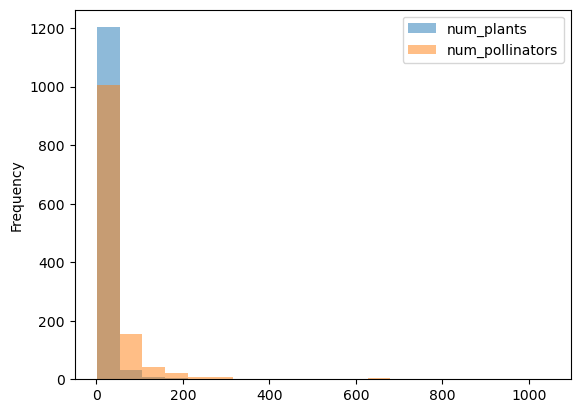

In [66]:
network_stats.plot(kind='hist', bins=20, stacked=False, alpha=.5)

In [69]:
network_stats["num_total"] = network_stats.num_plants + network_stats.num_pollinators
network_stats["mult_total"] = network_stats.num_plants * network_stats.num_pollinators
network_stats.loc[network_stats.num_total == network_stats.num_total.max()]

,network,num_plants,num_pollinators,num_total,mult_total
1203,../../data/networks//all/weighted/536.csv,456,1045,1501,476520
1252,../../data/networks//all/binarized_weighted/53...,456,1045,1501,476520


In [72]:
# remove unzipped dirs
for source in sources:
    src_dir = f"{networks_dir}/{source}/"
    os.system(f"rm -rf {src_dir}")